In [ ]:

#Imports and Setup
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
sys.path.append("C:/Users/USER/Desktop/Uni lvl 200/Project Repository/pneumonia-xray-detector/src")
from model import get_resnet18_model



# Optional: Grad-CAM if installed
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

    use_gradcam = True
except ImportError:
    print("GradCAM not installed, skipping GradCAM section.")
    use_gradcam = False

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
#Load Data
DATA_DIR = r"C:\Users\USER\Downloads\Pneumonia dataset\chest_xray"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transform)
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['NORMAL', 'PNEUMONIA']


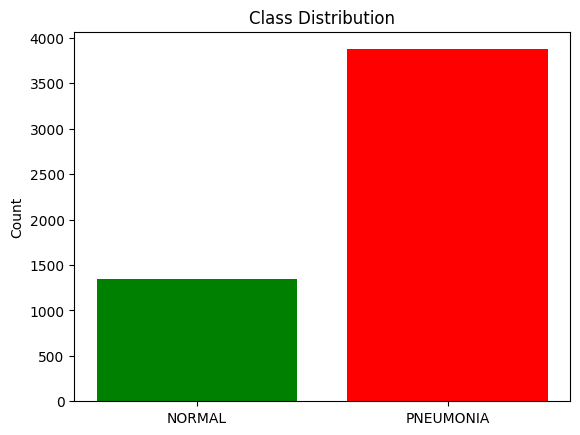

In [ ]:
# Visualize Class Distribution
from collections import Counter

labels = [label for _, label in train_dataset]
label_counts = Counter(labels)

plt.bar(class_names, [label_counts[0], label_counts[1]], color=["green", "red"])
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()


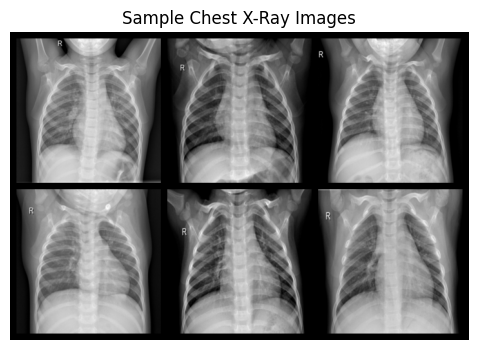

In [ ]:
# Visualize Sample Images
def show_images(dataset, num=6):
    imgs = [dataset[i][0] for i in range(num)]
    grid = make_grid(imgs, nrow=3, padding=10)
    npimg = grid.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.axis('off')
    plt.title("Sample Chest X-Ray Images")
    plt.show()

show_images(train_dataset, num=6)


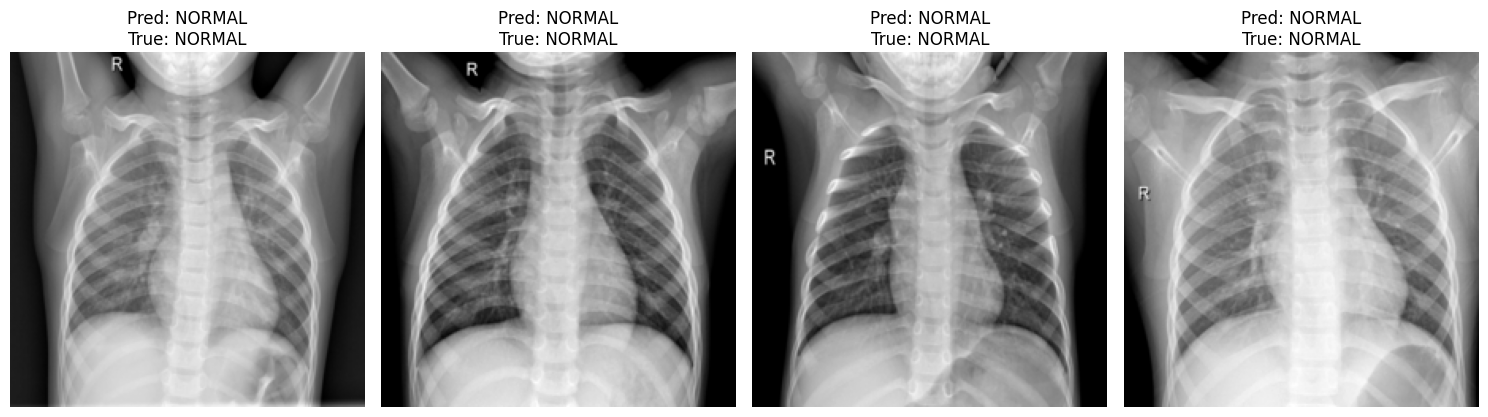

In [ ]:
#Load Model and Predict Random Samples
model = get_resnet18_model()
model.load_state_dict(torch.load("pneumonia_model.pth", map_location=device))
model.eval()
model.to(device)

def predict_and_show(dataset, n=4):
    fig, axs = plt.subplots(1, n, figsize=(15, 4))
    for i in range(n):
        img, true_label = dataset[i * 10]
        input_tensor = transforms.Normalize([0.485], [0.229])(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].set_title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[true_label]}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

predict_and_show(train_dataset)


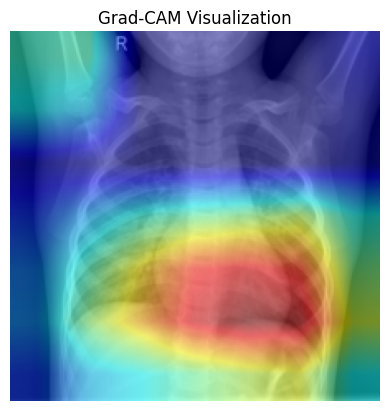

: 

In [ ]:
# Cell 6: Grad-CAM Visualization (optional)
if use_gradcam:
    img, _ = train_dataset[0]
    input_tensor = img.unsqueeze(0).to(device)  # Already normalized

    cam_extractor = GradCAM(model=model, target_layers=[model.layer4[-1]])
    targets = [ClassifierOutputTarget(1)]  # Index 1 = PNEUMONIA if 0 = NORMAL

    grayscale_cam = cam_extractor(input_tensor=input_tensor, targets=targets)[0]

    # Convert grayscale image to RGB (for visualization)
    img_np = img.squeeze().cpu().numpy()
    img_np = np.stack([img_np] * 3, axis=-1)
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title("Grad-CAM Visualization")
    plt.axis("off")
    plt.show()
